In [1]:
import sys
sys.path.insert(1, '../../unseen')
import math

import warnings
warnings.filterwarnings('ignore')

import cftime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client, LocalCluster

import fileio
import array_handling
import time_utils

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:46231 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 44.92 GiB


## Forecast climatology

In [3]:
cafe_file = '/g/data/xv83/dbi599/seatac/data/tasmax_cafe-c5-d60-pX-f6_19950501-20201101_seatac.zarr.zip'

In [4]:
ds_forecast = fileio.open_file(cafe_file)

In [5]:
ds_forecast

<xarray.Dataset>
Dimensions:    (ensemble: 96, init_date: 52, lead_time: 3650)
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * init_date  (init_date) object 1995-05-01 00:00:00 ... 2020-11-01 00:00:00
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 ... 3644 3645 3646 3647 3648 3649
    time       (lead_time, init_date) object dask.array<chunksize=(1825, 26), meta=np.ndarray>
Data variables:
    tasmax     (init_date, lead_time, ensemble) float32 dask.array<chunksize=(1, 50, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    history:    Wed Dec 01 14:03:45 2021: /g/data/xv83/dbi599/miniconda3/envs...
    title:      AccessOcean-AM2

In [6]:
ds_forecast_selection = time_utils.select_time_period(ds_forecast, ['2004-01-01', '2020-12-31'])

In [7]:
clim_forecast = ds_forecast_selection.groupby('init_date.month').mean(['ensemble', 'init_date'])

In [8]:
clim_forecast = clim_forecast.compute()

In [9]:
clim_forecast

<xarray.Dataset>
Dimensions:    (lead_time: 3650, month: 2)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 ... 3644 3645 3646 3647 3648 3649
  * month      (month) int64 5 11
Data variables:
    tasmax     (month, lead_time) float32 11.09 11.15 11.1 ... 7.463 7.219 6.896

## Observations

In [10]:
obs_file = '/g/data/xv83/dbi599/seatac/data/tasmax_GHCNv2_1948-2021_seatac.zarr.zip'

In [11]:
ds_obs = fileio.open_file(obs_file)

### Stack method

In [12]:
ds_forecast.sizes['lead_time']

3650

In [13]:
obs_stacked = array_handling.stack_by_init_date(ds_obs,
                                                init_dates=ds_forecast['init_date'],
                                                n_lead_steps=ds_forecast.sizes['lead_time'])

In [14]:
obs_stacked = obs_stacked.compute()

In [16]:
obs_stacked

<xarray.Dataset>
Dimensions:    (init_date: 52, lead_time: 3650)
Coordinates:
  * init_date  (init_date) object 1995-05-14 00:00:00 ... 2020-11-14 00:00:00
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 ... 3644 3645 3646 3647 3648 3649
    time       (init_date, lead_time) object 1995-05-14 00:00:00 ... 3000-01-...
Data variables:
    tasmax     (init_date, lead_time) float32 26.7 24.4 16.1 ... nan nan nan
Attributes: (12/22)
    Conventions:      CF-1.0
    climexp_url:      https://climexp.knmi.nl/gdcntmax.cgi?WMO=USW00024233
    comment:          
    contact_email:    ncdc.ghcnd@noaa.gov
    description:      SEATTLE TACOMA INTL AP, WA
    elevation:           113.0 m
    ...               ...
    station_code:     USW00024233
    station_country:  United States
    station_name:     SEATTLE_TACOMA_INTL_AP,_WA
    timestamp:        Mon Oct  4 03:26:54 2021
    title:            
    wmo_code:         72793

In [17]:
obs_stacked['time'].values[-1, 400:450]

array([cftime.DatetimeGregorian(2021, 12, 19, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12, 20, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12, 21, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12, 22, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12, 23, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12, 24, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12, 25, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12, 26, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12, 27, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12, 28, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12, 29, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12, 30, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2021, 12

In [49]:
#isnan = obs_stacked['time'].to_pandas().isna().to_numpy()
#new_times = obs_stacked['time'].where(np.invert(isnan), cftime.DatetimeGregorian(3000, 1, 1))
#obs_stacked = obs_stacked.assign_coords({'time': new_times})

In [18]:
obs_stacked_selection = time_utils.select_time_period(obs_stacked, ['2004-01-01', '2020-12-31'])

In [19]:
clim_obs = obs_stacked_selection.groupby('init_date.month').mean('init_date')

In [20]:
clim_obs = clim_obs.compute()

In [21]:
clim_obs

<xarray.Dataset>
Dimensions:    (lead_time: 3650, month: 2)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 ... 3644 3645 3646 3647 3648 3649
  * month      (month) int64 5 11
Data variables:
    tasmax     (month, lead_time) float32 20.17 19.68 19.35 ... 11.52 10.83

### Roll and duplicate method

In [22]:
ds_obs_trimmed = time_utils.select_time_period(ds_obs, ['2004-01-01', '2020-12-31'])

In [23]:
ds_obs_trimmed

<xarray.Dataset>
Dimensions:  (time: 6205)
Coordinates:
  * time     (time) object 2004-01-01 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    tasmax   (time) float32 dask.array<chunksize=(6205,), meta=np.ndarray>
Attributes: (12/22)
    Conventions:      CF-1.0
    climexp_url:      https://climexp.knmi.nl/gdcntmax.cgi?WMO=USW00024233
    comment:          
    contact_email:    ncdc.ghcnd@noaa.gov
    description:      SEATTLE TACOMA INTL AP, WA
    elevation:           113.0 m
    ...               ...
    station_code:     USW00024233
    station_country:  United States
    station_name:     SEATTLE_TACOMA_INTL_AP,_WA
    timestamp:        Mon Oct  4 03:26:54 2021
    title:            
    wmo_code:         72793

In [24]:
def daily_climatology(ds):
    """Calculate the daily climatology"""
    
    clim = ds.groupby('time.dayofyear').mean('time')
    
    max_day = int(clim['dayofyear'].values.max())
    assert max_day in [365, 366]
    if max_day == 366:
        noleap_idx = np.delete(np.arange(0, 366), 59)
        clim = clim.isel({'dayofyear': noleap_idx})
        clim = clim.assign_coords({'dayofyear': np.arange(1, 366)})
    
    return clim

#TODO: Add time period selection

In [25]:
clim_obs_my_method = daily_climatology(ds_obs_trimmed)

In [26]:
clim_obs_my_method

<xarray.Dataset>
Dimensions:    (dayofyear: 365)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    tasmax     (dayofyear) float32 dask.array<chunksize=(1,), meta=np.ndarray>

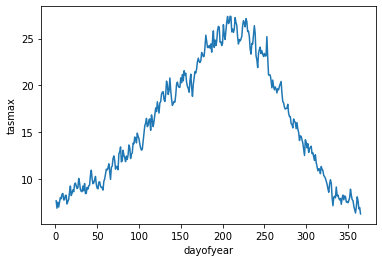

In [27]:
clim_obs_my_method['tasmax'].plot()
plt.show()

In [28]:
def roll_daily_climatology(clim, forecast_ds):
    """Roll observed daily climatology to match forecast initial dates"""
    
    n_lead_times = forecast_ds['lead_time'].size
    n_cycles = n_lead_times / 365
    assert n_cycles.is_integer()
    
    init_months = np.unique(forecast_ds['init_date'].dt.month.values)
    init_daysofyear = forecast_ds['init_date'].dt.dayofyear.values[0:len(init_months)]
    rolled_clim_list = []
    for month, dayofyear in zip(init_months, init_daysofyear):
        roll_number = 365 - (dayofyear - 1)
        clim_shifted = clim.roll(dayofyear=roll_number, roll_coords=True)
        first_day = int(clim_shifted['dayofyear'][0])
        assert first_day == dayofyear
        clim_shifted = clim_shifted.rename({'dayofyear': 'lead_time'})
        clim_shifted = xr.concat([clim_shifted]*int(n_cycles), dim='lead_time')
        clim_shifted = clim_shifted.assign_coords({'lead_time': forecast_ds['lead_time']})
        clim_shifted = clim_shifted.assign_coords({'month': month})
        rolled_clim_list.append(clim_shifted)
    rolled_clim = xr.concat(rolled_clim_list, dim='month')
        
    return rolled_clim

In [29]:
clim_obs_rolled = roll_daily_climatology(clim_obs_my_method, ds_forecast)

In [30]:
clim_obs_rolled

<xarray.Dataset>
Dimensions:    (lead_time: 3650, month: 2)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 ... 3644 3645 3646 3647 3648 3649
  * month      (month) int64 5 11
Data variables:
    tasmax     (month, lead_time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>

## Plots

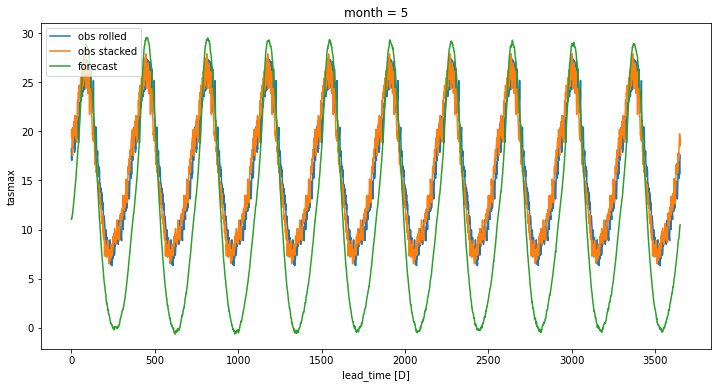

In [31]:
plt.figure(figsize=[12,6])
clim_obs_rolled['tasmax'].isel({'month': 0}).plot(label='obs rolled')
clim_obs['tasmax'].isel({'month': 0}).plot(label='obs stacked')
clim_forecast['tasmax'].isel({'month': 0}).plot(label='forecast')
plt.legend()
plt.show()

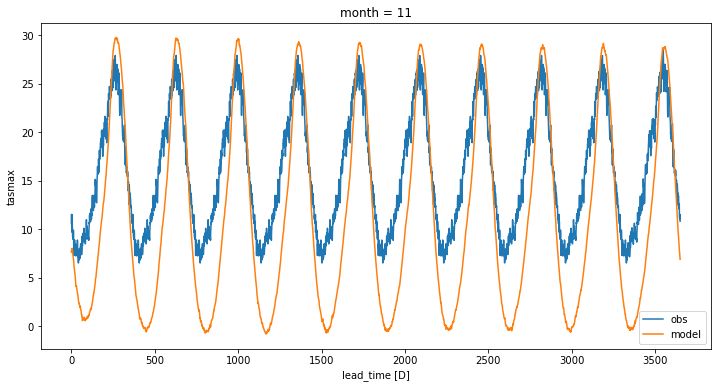

In [89]:
plt.figure(figsize=[12,6])
clim_obs['tasmax'].isel({'month': 1}).plot(label='obs')
clim_forecast['tasmax'].isel({'month': 1}).plot(label='model')
plt.legend()
plt.show()

In [90]:
bias = clim_forecast['tasmax'] - clim_obs['tasmax']

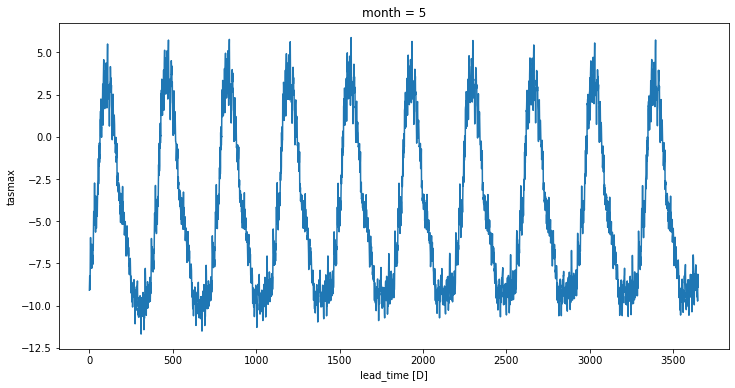

In [91]:
plt.figure(figsize=[12,6])
bias.isel({'month': 0}).plot()
plt.show()

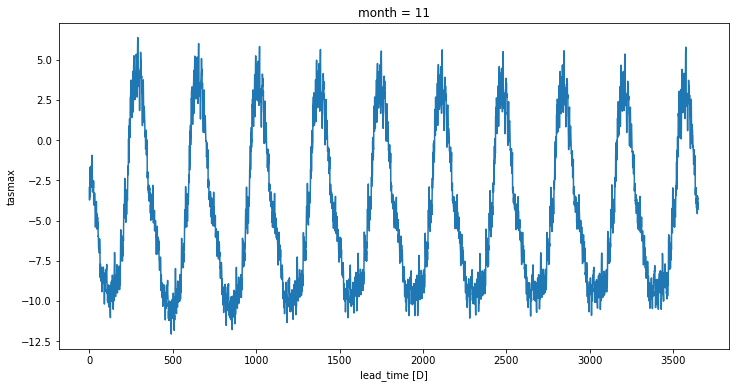

In [92]:
plt.figure(figsize=[12,6])
bias.isel({'month': 1}).plot()
plt.show()

The seasonal cycle of tmax is greater in the model so (relative to obs) the bias is positive in the summer and negative in winter.

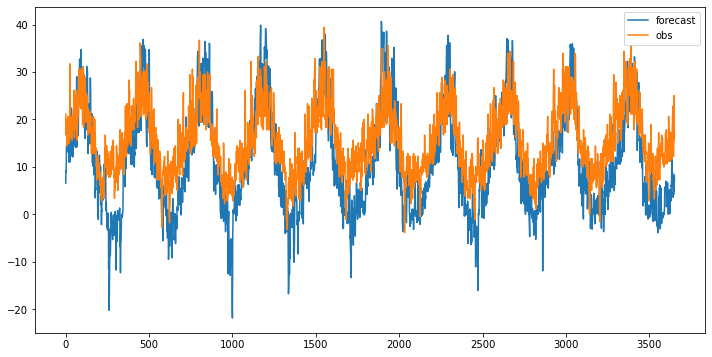

In [88]:
plt.figure(figsize=[12,6])
plt.plot(np.arange(1, 3651), ds_forecast['tasmax'].isel({'ensemble': 50, 'init_date': 20}).values, label='forecast')
plt.plot(np.arange(1, 3651), ds_obs['tasmax'].sel(time=slice('2005-05-01', '2015-04-30')).values, label='obs')
plt.legend()
plt.show()

In [83]:
ds_forecast['tasmax'].isel({'ensemble': 1, 'init_date': 20})

<xarray.DataArray 'tasmax' (lead_time: 3650)>
dask.array<getitem, shape=(3650,), dtype=float32, chunksize=(50,), chunktype=numpy.ndarray>
Coordinates:
    ensemble   int64 2
    init_date  object 2005-05-01 00:00:00
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 ... 3644 3645 3646 3647 3648 3649
    time       (lead_time) object dask.array<chunksize=(1825,), meta=np.ndarray>
Attributes:
    cell_methods:   time: max
    long_name:      temperature at 2 m
    time_avg_info:  average_T1,average_T2,average_DT
    units:          °C
    valid_range:    [100.0, 400.0]